In [1]:
%cd supervised
%load_ext autoreload
%autoreload 2

import data
import train
import evaluate
import models
import torch

C:\Users\mdejo\Documents\Projects\Masterthesis\supervised


In [2]:
import pickle

def save(data, fname):
    with open(fname, 'wb') as f:
        pickle.dump(data, f)
    
def load(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [31]:
dataset1, validset1, testset1 = evaluate.load_dataset(9, 0, 1, True)
dataset2, validset2, testset2 = evaluate.load_dataset(9, 1, 1, True)

Creating dictionary: 100%|█████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.83it/s]


In [13]:
import numpy as np
from collections import Counter
print(Counter(np.shape(s.clusters_gmm)[1] for s in dataset1))
print(Counter(np.shape(s.clusters_gmm)[1] for s in dataset2))

Counter({22: 3890})
Counter({33: 3890})


In [33]:
assert(len([d.label for d in dataset1 if np.all(d.label == 1)])
       ==len([d.label for d in dataset1 if np.all(d.label == 0)]))

for d1, d2 in zip(dataset1, dataset2):
    assert(np.all([w in d2.X_words for w in np.nditer(d1.X_words)]))
    assert(np.all([w in d2.X_chars for w in np.nditer(d1.X_chars)]))
    assert(np.all(d1.label == d2.label))

In [19]:
%debug

> <ipython-input-18-fc5c80706b59>(5)<module>()
      3 
      4 for d1, d2 in zip(dataset1, dataset2):
----> 5     assert(np.all([w in d2.X_words for w in d1.X_words]))
      6     assert(np.all([w in d2.X_chars for w in d1.X_chars]))
      7     assert(np.all(d1.label == d2.label))

ipdb> d1
Sample(
    (1, 14)
    (1, 67)
    (1, 18)
    (1, 22)
    (1,)
)
ipdb> d2
Sample(
    (1, 20)
    (1, 82)
    (1, 27)
    (1, 33)
    (1,)
)
ipdb> [w in d2.X_words for w in d1.X_words]


c:\users\mdejo\miniconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


[False]
ipdb> d1.X_words
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
ipdb> [i for i in d1.X_words]
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
ipdb> d1.X_chars
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
ipdb> dataset1.vocab
*** AttributeError: 'GermanDataset' object has no attribute 'vocab'
ipdb> q


# Training size, full cross validation

In [ ]:
# main test

window_size = 2
num_clusters = 9
dataset, validset = load_dataset(num_clusters, window_size)

params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

optim_fn = lambda p: torch.optim.Adadelta(p)
model_fns = [lambda r: models.NoClusterLabels(r, params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
#             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]

baseline = {}
kmeans = {}
gmm = {}

for n in [50, 100, 400, 800, 1200, 1600, 2000, 2400]:
    values = evaluate.cross_val(10, n, model_fns, [False, False], optim_fn, dataset, params,
                                early_stopping=10,
                                validation_set=validset,
                                testset=None)
    baseline[n] = [v[0] for v in values]
    kmeans[n] = [v[1] for v in values]
#    gmm[n] = [v[2] for v in values]

In [ ]:
d = {s: {'Baseline': baseline[s],
         'K-Means': kmeans[s],
#         'Mixture model': gmm[s],
        }
    for s in baseline.keys()
}
evaluate.analyze_tseries(d, 'number of training samples', 'model', '../report/figures/results/main_window4_oldtest')
evaluate.analyze_size(d, 'number of samples', 'model', '../report/figures/results/main_window4_oldtest')

In [ ]:
evaluate.analyze_wrapper(baseline, kmeans, None, 'model', '../report/figures/results/main_window4_data_oldtest')
#evaluate.analyze_wrapper(baseline, kmeans, gmm, 'model')

# Training size, older test set

In [ ]:
# test on old data

window_size = 4
num_clusters = 9
dataset, validset, testset = load_dataset(num_clusters, window_size, True)

params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

optim_fn = lambda p: torch.optim.Adadelta(p)
model_fns = [lambda r: models.NoClusterLabels(r, params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
#             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]

baseline = {}
kmeans = {}
gmm = {}

for n in [50, 100, 400, 800, 1200, 1600, 2000, 2400]:
    values = evaluate.cross_val(10, n, model_fns, [False, False], optim_fn, dataset, params,
                                early_stopping=10,
                                validation_set=validset,
                                testset=testset)
    baseline[n] = [v[0] for v in values]
    kmeans[n] = [v[1] for v in values]
#    gmm[n] = [v[2] for v in values]

# Window size, full cross validation

In [34]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=100,
    max_norm=3,
)

#optim_fn = lambda p: torch.optim.Adadelta(p)
optim_fn = lambda p: torch.optim.Adam(p, weight_decay=0.0001)
model_fns = [lambda r: models.NoClusterLabels(r, params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
             
             lambda r: models.NoClusterLabels(r, char_params.dropout),
             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, char_params.dropout)]
    
#baseline = {}
#kmeans = {}
#char_baseline = {}
#char_kmeans = {}

for window_size in [1]:
    num_clusters = 9
    dataset, validset = evaluate.load_dataset(num_clusters, window_size)

    values = evaluate.cross_val(5, 1600, model_fns, [False, False, False, False], optim_fn, dataset,
                                params=[params, params, char_params, char_params],
                                early_stopping=10,
                                validation_set=None,
                                batch_size=128,
                                testset=None)
    baseline[window_size] = [v[0] for v in values]
    kmeans[window_size] = [v[1] for v in values]
    char_baseline[window_size] = [v[2] for v in values]
    char_kmeans[window_size] = [v[3] for v in values]

Creating dictionary:  71%|█████████████████████████████████████████████▉                   | 12/17 [00:02<00:01,  4.92it/s]


KeyboardInterrupt: 

In [ ]:
d = {
    "WordCNN": {
        s: {
            'Baseline': baseline[s],
            'K-Means': kmeans[s],
        }
        for s in baseline.keys()
    },
    "CharCNN": {
        s: {
            'Baseline': char_baseline[s],
            'K-Means': char_kmeans[s],
        }
        for s in baseline.keys()
    }
}
#evaluate.analyze_tseries(d, 'window size', 'model')
evaluate.analyze_cnns(d, "window size", "model", "../report/figures/results/1600-windowsize")

# Window size, older testset

In [35]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

num_clusters = 9
k = 5
splitter = evaluate.StratifiedShuffleSplit(
    n_splits=k,
    train_size=2000,
    test_size=None,
    random_state=100,
)

old_kmeans_w = {}
old_gmm_w = {}
old_char_kmeans_w = {}
old_char_gmm_w = {}

for window_size in [(0, 0), (0, 1), (1, 1)]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, sum(window_size) + 1, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, sum(window_size) + 1, char_params.dropout),
    ]
    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size[0], window_size[1], True)

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, True, False, True], optim_fn,
                                dataset,
                                params=[params, params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    old_kmeans_w[window_size] = [v[0] for v in values]
    old_gmm_w[window_size] = [v[1] for v in values]
    old_char_kmeans_w[window_size] = [v[2] for v in values]
    old_char_gmm_w[window_size] = [v[3] for v in values]

Creating dictionary: 100%|█████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.93it/s]

  0%|                                                                                                | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...,  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  12%|██████▍                                            | 25/200 [00:25<02:56,  1.01s/it, f1=0.947, Δf1=-0.00152]

 20%|█████████████████▌                                                                      | 1/5 [01:16<05:05, 76.41s/it]

[3442 1761 2281 ...,  231 1316 2548]


Training:  10%|█████                                              | 20/200 [00:19<02:57,  1.01it/s, f1=0.944, Δf1=-0.00275]

 40%|███████████████████████████████████▏                                                    | 2/5 [02:59<04:29, 89.85s/it]

[  10  683 2628 ..., 1125 1557 3658]


Training:  15%|███████▊                                            | 30/200 [00:33<03:11,  1.12s/it, f1=0.946, Δf1=-0.0033]

 60%|████████████████████████████████████████████████████▊                                   | 3/5 [04:50<03:13, 96.96s/it]

[2362 3138 1297 ...,  205 2287 1247]


Training:  10%|█████                                             | 20/200 [00:22<03:23,  1.13s/it, f1=0.943, Δf1=-0.000565]

 80%|█████████████████████████████████████████████████████████████████████▌                 | 4/5 [06:53<01:43, 103.35s/it]

[3690 3243 2192 ..., 2801 1146 2757]


Training:  12%|██████▍                                            | 25/200 [00:26<03:08,  1.07s/it, f1=0.946, Δf1=-0.00633]

Creating dictionary: 100%|█████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.56it/s]

  0%|                                                                                                | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...,  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  12%|██████▍                                            | 25/200 [00:30<03:34,  1.22s/it, f1=0.928, Δf1=-0.00113]

 20%|█████████████████▍                                                                     | 1/5 [01:41<06:44, 101.10s/it]

[3442 1761 2281 ...,  231 1316 2548]


Training:  12%|██████▍                                            | 25/200 [00:29<03:26,  1.18s/it, f1=0.922, Δf1=-0.00486]

 40%|██████████████████████████████████▊                                                    | 2/5 [03:29<05:14, 104.69s/it]

[  10  683 2628 ..., 1125 1557 3658]


Training:  10%|█████                                              | 20/200 [00:23<03:34,  1.19s/it, f1=0.919, Δf1=-0.00253]

 60%|████████████████████████████████████████████████████▏                                  | 3/5 [05:16<03:31, 105.55s/it]

[2362 3138 1297 ...,  205 2287 1247]


Training:  28%|█████████████▊                                    | 55/200 [01:04<02:48,  1.17s/it, f1=0.935, Δf1=-0.000548]

 80%|█████████████████████████████████████████████████████████████████████▌                 | 4/5 [07:57<01:59, 119.47s/it]

[3690 3243 2192 ..., 2801 1146 2757]


Training:  15%|███████▋                                           | 30/200 [00:32<03:01,  1.07s/it, f1=0.927, Δf1=-0.00219]

Creating dictionary: 100%|█████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.87it/s]

  0%|                                                                                                | 0/5 [00:00<?, ?it/s]

[2131  725 1801 ...,  260 3341 1694]
2000 training samples, 1132 testing samples


Training:  18%|████████▊                                         | 35/200 [00:44<03:31,  1.28s/it, f1=0.933, Δf1=-0.000451]

 20%|█████████████████▍                                                                     | 1/5 [02:21<09:26, 141.67s/it]

[3442 1761 2281 ...,  231 1316 2548]


Training:   8%|███▊                                               | 15/200 [00:20<04:12,  1.37s/it, f1=0.933, Δf1=-0.00152]

 40%|██████████████████████████████████▊                                                    | 2/5 [03:58<05:58, 119.40s/it]

[  10  683 2628 ..., 1125 1557 3658]


Training:  12%|██████▎                                           | 25/200 [00:29<03:25,  1.17s/it, f1=0.931, Δf1=-0.000671]

 60%|████████████████████████████████████████████████████▏                                  | 3/5 [06:14<04:09, 124.72s/it]

[2362 3138 1297 ...,  205 2287 1247]


Training:  12%|██████▍                                            | 25/200 [00:29<03:29,  1.20s/it, f1=0.929, Δf1=-0.00369]

 80%|█████████████████████████████████████████████████████████████████████▌                 | 4/5 [08:11<02:02, 122.77s/it]

[3690 3243 2192 ..., 2801 1146 2757]


Training:  12%|███████▎                                                  | 25/200 [00:30<03:33,  1.22s/it, f1=0.932, Δf1=0]

100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [10:09<00:00, 121.82s/it]


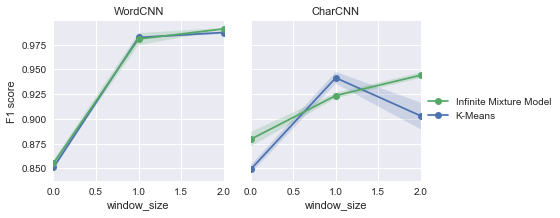

In [40]:
d = {
    "WordCNN": {
        sum(s): {
            'K-Means': old_kmeans_w[s],
            'Infinite Mixture Model': old_gmm_w[s],
        }
        for s in old_kmeans_w.keys()
    },
    "CharCNN": {
        sum(s): {
            'K-Means': old_char_kmeans_w[s],
            'Infinite Mixture Model': old_char_gmm_w[s],
        }
        for s in old_kmeans_w.keys()
    }
}
evaluate.analyze_cnns(d, "window_size", "model")
#evaluate.analyze_cnns(d, "window size", "model", "../report/figures/results/2000-windowsize-old")

In [ ]:
save((old_baseline, old_kmeans, old_char_baseline, old_char_kmeans), "1600-windowsize-old.pkl")

# Number of clusters, full cross validation

In [ ]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=100,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

optim_fn = lambda p: torch.optim.Adadelta(p)
model_fns = [lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
#             lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout)]
    
kmeans = {}
gmm = {}

for num_clusters in [2, 3, 5, 7, 9, 15, 30]:
    window_size = 5
    dataset, validset = load_dataset(num_clusters, window_size)

    values = evaluate.cross_val(10, 1200, model_fns, [False], optim_fn, dataset, params,
                                early_stopping=10,
                                validation_set=validset,
                                testset=None)
    kmeans[num_clusters] = [v[0] for v in values]
    gmm[num_clusters] = [v[1] for v in values]

In [ ]:
d = {s: {'K-Means': kmeans[s],
         #'Mixture model': gmm[s],
        }
    for s in kmeans.keys()
}
#evaluate.analyze_tseries(d, 'k', 'model')
evaluate.analyze_size(d, 'k', 'model', '../report/figures/results/800-numcluster')
evaluate.analyze_tseries(d, 'k', 'model', '../report/figures/results/800-numcluster')

# Number of clusters on old training set

In [3]:
params = train.CNNParams(
    embed_size=100,
    dropout=0.5,
    epochs=200,
    filters=[(33, 3), (33, 5), (33, 7)],
    num_layers=1,
    max_norm=3,
)

char_params = train.CharCNNParams(
    dropout=0.5,
    epochs=200,
    max_norm=3,
)

window_size = 2
k = 5
splitter = evaluate.StratifiedShuffleSplit(
    n_splits=k,
    train_size=2000,
    test_size=None,
    random_state=100,
)

old_kmeans_cls = {}
old_gmm_cls = {}
old_char_kmeans_cls = {}
old_char_gmm_cls = {}

for num_clusters in [2, 3, 5, 7, 9, 15]:
    optim_fn = lambda p: torch.optim.Adadelta(p)
    model_fns = [
        lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, window_size, params.dropout),
        lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, char_params.dropout),
        lambda r: models.CategoricalClusterLabels(r, 11, window_size, char_params.dropout),
    ]
    dataset, validset, testset = evaluate.load_dataset(num_clusters, window_size, True)

    splitter.random_state = 100
    values = evaluate.cross_val(k, splitter, model_fns, [False, True, False, True], optim_fn,
                                dataset,
                                params=[params, params, char_params, char_params],
                                early_stopping=2,
                                validation_set=validset,
                                batch_size=128,
                                testset=testset)
    old_kmeans_cls[num_clusters] = [v[0] for v in values]
    old_gmm_cls[num_clusters] = [v[1] for v in values]
    old_char_kmeans_cls[num_clusters] = [v[2] for v in values]
    old_char_gmm_cls[num_clusters] = [v[3] for v in values]


  0%|          | 0/5 [00:00<?, ?it/s]

[2131  262 1814 ...  309 3341 1707]
2000 training samples, 1132 testing samples


Training:  18%|█▊        | 35/200 [00:30<02:23,  1.15it/s, f1=0.964, Δf1=0]       

 20%|██        | 1/5 [02:10<08:43, 130.81s/it]

[3560 1774 2585 ...  231 1302 2319]


Training:  22%|██▎       | 45/200 [00:38<02:12,  1.17it/s, f1=0.948, Δf1=-0.000545]

 40%|████      | 2/5 [04:22<06:33, 131.04s/it]

[  10  732 2399 ... 1125 1416 3419]


Training:  50%|█████     | 100/200 [01:25<01:25,  1.17it/s, f1=0.937, Δf1=0]       

 60%|██████    | 3/5 [06:42<04:28, 134.13s/it]

[2666 3225 1283 ...  205 2591 1247]


Training:  12%|█▎        | 25/200 [00:21<02:30,  1.16it/s, f1=0.903, Δf1=-0.00916]

 80%|████████  | 4/5 [08:16<02:04, 124.16s/it]

[3451 3074 2192 ... 2801 1146 2528]


Training:  25%|██▌       | 50/200 [00:42<02:07,  1.17it/s, f1=0.944, Δf1=-0.00045]

100%|██████████| 5/5 [10:03<00:00, 120.66s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  262 1814 ...  309 3341 1707]
2000 training samples, 1132 testing samples


Training:  15%|█▌        | 30/200 [00:25<02:27,  1.16it/s, f1=0.954, Δf1=-0.00131]

 20%|██        | 1/5 [01:40<06:42, 100.73s/it]

[3560 1774 2585 ...  231 1302 2319]


Training:  22%|██▎       | 45/200 [00:38<02:14,  1.16it/s, f1=0.963, Δf1=0]      

 40%|████      | 2/5 [03:28<05:13, 104.41s/it]

[  10  732 2399 ... 1125 1416 3419]


Training:  22%|██▎       | 45/200 [00:39<02:15,  1.14it/s, f1=0.952, Δf1=0]       

 60%|██████    | 3/5 [05:00<03:20, 100.02s/it]

[2666 3225 1283 ...  205 2591 1247]


Training:  15%|█▌        | 30/200 [00:25<02:26,  1.16it/s, f1=0.927, Δf1=-0.000714]

 80%|████████  | 4/5 [06:33<01:38, 98.43s/it] 

[3451 3074 2192 ... 2801 1146 2528]


Training:  22%|██▎       | 45/200 [00:38<02:13,  1.16it/s, f1=0.954, Δf1=-0.000528]

100%|██████████| 5/5 [08:04<00:00, 96.88s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[2131  262 1814 ...  309 3341 1707]
2000 training samples, 1132 testing samples


Training:  25%|██▌       | 50/200 [00:43<02:11,  1.14it/s, f1=0.955, Δf1=0]        

 20%|██        | 1/5 [02:47<11:08, 167.20s/it]

[3560 1774 2585 ...  231 1302 2319]


Training:  20%|██        | 40/200 [00:35<02:23,  1.11it/s, f1=0.958, Δf1=0]        

 40%|████      | 2/5 [04:21<06:32, 131.00s/it]

[  10  732 2399 ... 1125 1416 3419]


Training:  20%|██        | 40/200 [00:34<02:18,  1.16it/s, f1=0.963, Δf1=0]      

 60%|██████    | 3/5 [06:38<04:25, 132.67s/it]

[2666 3225 1283 ...  205 2591 1247]


Training:  12%|█▎        | 25/200 [00:21<02:31,  1.15it/s, f1=0.907, Δf1=-0.0409]

 80%|████████  | 4/5 [07:54<01:58, 118.70s/it]

[3451 3074 2192 ... 2801 1146 2528]


Training:  42%|████▎     | 85/200 [01:14<01:40,  1.14it/s, f1=0.946, Δf1=-0.000481]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.58it/s]


[17695  8700 43259 ... 11922 40115  8304]
Retrieved 987 positive samples, 70985 negative samples.
[28755 33778 19069 ... 88902 79687 95980]
Retrieved 1945 positive samples, 95605 negative samples.
[ 2317 11181  8898 ... 12409 17033 12293]
Retrieved 566 positive samples, 20841 negative samples.



  0%|          | 0/5 [00:00<?, ?it/s]

[2131  262 1814 ...  309 3341 1707]
2000 training samples, 1132 testing samples


Training:  32%|███▎      | 65/200 [01:02<02:09,  1.04it/s, f1=0.944, Δf1=-0.000971]

 20%|██        | 1/5 [02:41<10:45, 161.44s/it]

[3560 1774 2585 ...  231 1302 2319]


Training:  12%|█▎        | 25/200 [00:23<02:44,  1.06it/s, f1=0.943, Δf1=-0.00128]

 40%|████      | 2/5 [04:38<06:57, 139.18s/it]

[  10  732 2399 ... 1125 1416 3419]


Training:  28%|██▊       | 55/200 [00:51<02:15,  1.07it/s, f1=0.939, Δf1=-6.32e-05]

 60%|██████    | 3/5 [06:36<04:24, 132.17s/it]

[2666 3225 1283 ...  205 2591 1247]


Training:  12%|█▎        | 25/200 [00:23<02:45,  1.06it/s, f1=0.941, Δf1=-0.00451]

 80%|████████  | 4/5 [09:10<02:17, 137.64s/it]

[3451 3074 2192 ... 2801 1146 2528]


Training:  12%|█▎        | 25/200 [00:23<02:44,  1.06it/s, f1=0.93, Δf1=-0.00106]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.96it/s]


[17695  8700 43259 ... 11922 40115  8304]
Retrieved 987 positive samples, 70985 negative samples.
[28755 33778 19069 ... 88902 79687 95980]
Retrieved 1945 positive samples, 95605 negative samples.
[ 2317 11181  8898 ... 12409 17033 12293]
Retrieved 566 positive samples, 20841 negative samples.



  0%|          | 0/5 [00:00<?, ?it/s]

[2131  262 1814 ...  309 3341 1707]
2000 training samples, 1132 testing samples


Training:  30%|███       | 60/200 [01:00<02:20,  1.00s/it, f1=0.959, Δf1=0]       

 20%|██        | 1/5 [02:27<09:50, 147.57s/it]

[3560 1774 2585 ...  231 1302 2319]


Training:  15%|█▌        | 30/200 [00:28<02:44,  1.04it/s, f1=0.94, Δf1=-0.000866]

 40%|████      | 2/5 [04:46<07:09, 143.17s/it]

[  10  732 2399 ... 1125 1416 3419]


Training:  42%|████▎     | 85/200 [01:26<01:56,  1.01s/it, f1=0.943, Δf1=-0.000545]

 60%|██████    | 3/5 [08:10<05:26, 163.34s/it]

[2666 3225 1283 ...  205 2591 1247]


Training:  12%|█▎        | 25/200 [00:23<02:47,  1.04it/s, f1=0.937, Δf1=-0.0146]

 80%|████████  | 4/5 [09:43<02:25, 145.97s/it]

[3451 3074 2192 ... 2801 1146 2528]


Training:  15%|█▌        | 30/200 [00:30<02:51,  1.01s/it, f1=0.954, Δf1=-0.00119]

Creating dictionary: 100%|██████████| 17/17 [00:03<00:00,  4.55it/s]


[17695  8700 43259 ... 11922 40115  8304]
Retrieved 987 positive samples, 70985 negative samples.
[28755 33778 19069 ... 88902 79687 95980]
Retrieved 1945 positive samples, 95605 negative samples.
[ 2317 11181  8898 ... 12409 17033 12293]
Retrieved 566 positive samples, 20841 negative samples.



  0%|          | 0/5 [00:00<?, ?it/s]

[2131  262 1814 ...  309 3341 1707]
2000 training samples, 1132 testing samples


Training:  30%|███       | 60/200 [01:00<02:21,  1.01s/it, f1=0.949, Δf1=0]       

 20%|██        | 1/5 [02:24<09:36, 144.18s/it]

[3560 1774 2585 ...  231 1302 2319]


Training:  28%|██▊       | 55/200 [00:53<02:20,  1.03it/s, f1=0.941, Δf1=-0.000235]

 40%|████      | 2/5 [04:47<07:11, 143.99s/it]

[  10  732 2399 ... 1125 1416 3419]


Training:  32%|███▎      | 65/200 [01:03<02:12,  1.02it/s, f1=0.922, Δf1=0]       

 60%|██████    | 3/5 [08:05<05:23, 161.80s/it]

[2666 3225 1283 ...  205 2591 1247]


Training:  18%|█▊        | 35/200 [00:33<02:39,  1.03it/s, f1=0.957, Δf1=-0.00193]

 80%|████████  | 4/5 [09:48<02:27, 147.07s/it]

[3451 3074 2192 ... 2801 1146 2528]


Training:  12%|█▎        | 25/200 [00:24<02:49,  1.03it/s, f1=0.938, Δf1=-0.00558]

100%|██████████| 5/5 [11:51<00:00, 142.25s/it]


In [4]:
(old_kmeans_cls, old_gmm_cls, old_char_kmeans_cls, old_char_gmm_cls) = load("1600-numclusters-old.pkl")

/usr/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


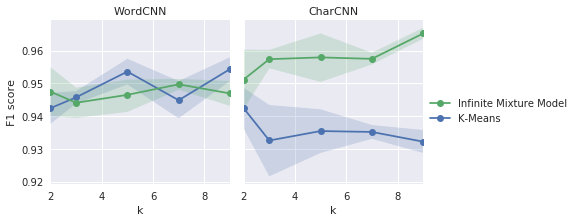

In [7]:
d = {
    "WordCNN": {
        s: {
            'K-Means': old_kmeans_cls[s],
            'Infinite Mixture Model': old_gmm_cls[s],
        }
        for s in old_kmeans_cls.keys()
    },
    "CharCNN": {
        s: {
            'K-Means': old_char_kmeans_cls[s],
            'Infinite Mixture Model': old_char_gmm_cls[s],
        }
        for s in [2, 3, 5, 7, 9]
    }
}
#evaluate.analyze_cnns(d, "k", "model")
evaluate.analyze_cnns(d, "k", "model", "../report/figures/results/2000-numclusters-old")

In [6]:
save((old_kmeans_cls, old_gmm_cls, old_char_kmeans_cls, old_char_gmm_cls), "2000-numclusters-old.pkl")